In [29]:
import numpy as np
import pandas as pd
import requests
import os
import time
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from sklearn.linear_model import LinearRegression

In [10]:
def get_tickers():
    url = "https://iss.moex.com/iss/engines/stock/markets/shares/securities.json"
    response = requests.get(url)
    data = response.json()

    columns = data["securities"]["columns"]
    rows = data["securities"]["data"]
    df = pd.DataFrame(rows, columns=columns)

    # Фильтрация: только основная доска (TQBR) и цена больше 0
    df = df[(df["BOARDID"] == "TQBR") & (pd.to_numeric(df["PREVPRICE"], errors="coerce") > 0)]
    df.reset_index(drop=True, inplace=True)

    # Список тикеров
    tickers = df["SECID"].dropna().unique().tolist()
    return tickers

# Проверим
tickers = get_tickers()
print(f"Найдено {len(tickers)} тикеров.")
print(tickers[:10])

Найдено 259 тикеров.
['ABIO', 'ABRD', 'AFKS', 'AFLT', 'AGRO', 'AKRN', 'ALRS', 'AMEZ', 'APRI', 'APTK']


In [ ]:
def get_tickers():
    url = "https://iss.moex.com/iss/engines/stock/markets/shares/securities.json"
    response = requests.get(url)
    data = response.json()

    columns = data["securities"]["columns"]
    rows = data["securities"]["data"]
    df = pd.DataFrame(rows, columns=columns)

    df = df[(df["BOARDID"] == "TQBR") & (pd.to_numeric(df["PREVPRICE"], errors="coerce") > 0)]
    df.reset_index(drop=True, inplace=True)
    tickers = df["SECID"].dropna().unique().tolist()
    return tickers

In [15]:
def get_history(ticker, start_date, end_date):
    url = f"https://iss.moex.com/iss/history/engines/stock/markets/shares/securities/{ticker}.json"
    all_data = []

    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    step = pd.Timedelta(days=100)  # API часто ограничен по числу дней

    while start <= end:
        period_end = min(start + step, end)
        params = {
            "from": start.strftime("%Y-%m-%d"),
            "till": period_end.strftime("%Y-%m-%d")
        }

        try:
            response = requests.get(url, params=params)
            data = response.json()
            columns = data["history"]["columns"]
            rows = data["history"]["data"]
            df = pd.DataFrame(rows, columns=columns)

            if "TRADEDATE" in df.columns and "CLOSE" in df.columns:
                df = df[["TRADEDATE", "CLOSE"]]
                df["TRADEDATE"] = pd.to_datetime(df["TRADEDATE"])
                df["CLOSE"] = pd.to_numeric(df["CLOSE"], errors="coerce")
                df.dropna(inplace=True)
                all_data.append(df)

        except Exception as e:
            print(f"Ошибка при загрузке {ticker}: {e}")

        start = period_end + pd.Timedelta(days=1)
        time.sleep(0.1)

    if all_data:
        result = pd.concat(all_data)
        result.drop_duplicates(subset="TRADEDATE", keep="last", inplace=True)
        return result
    else:
        return pd.DataFrame()

In [19]:
tickers = get_tickers()
print(f"Найдено {len(tickers)} тикеров.")

start_date = "2024-06-02"
end_date = pd.Timestamp.today().strftime("%Y-%m-%d")

os.makedirs("moex_data", exist_ok=True)

for ticker in tickers:
    df = get_history(ticker, start_date, end_date)

    if df.empty:
        print(f"{ticker}: данных нет.")
        continue

    df.to_csv(f"moex_data/{ticker}.csv", index=False)
    print(f"{ticker}: сохранено {len(df)} строк.")

Найдено 259 тикеров.
ABIO: сохранено 254 строк.
ABRD: сохранено 254 строк.
AFKS: сохранено 192 строк.
AFLT: сохранено 199 строк.
AGRO: сохранено 130 строк.
AKRN: сохранено 254 строк.
ALRS: сохранено 194 строк.
AMEZ: сохранено 192 строк.
APRI: сохранено 214 строк.
APTK: сохранено 254 строк.
AQUA: сохранено 254 строк.
ARSA: сохранено 254 строк.
ASSB: сохранено 254 строк.
ASTR: сохранено 254 строк.
AVAN: сохранено 254 строк.
BANE: сохранено 254 строк.
BANEP: сохранено 254 строк.
BELU: сохранено 250 строк.
BISVP: сохранено 254 строк.
BLNG: сохранено 254 строк.
BRZL: сохранено 254 строк.
BSPB: сохранено 245 строк.
BSPBP: сохранено 254 строк.
CARM: сохранено 254 строк.
CBOM: сохранено 227 строк.
CHGZ: сохранено 254 строк.
CHKZ: сохранено 253 строк.
CHMF: сохранено 254 строк.
CHMK: сохранено 254 строк.
CNRU: сохранено 40 строк.
CNTL: сохранено 254 строк.
CNTLP: сохранено 254 строк.
DATA: сохранено 169 строк.
DELI: сохранено 254 строк.
DIAS: сохранено 254 строк.
DIOD: сохранено 254 строк.
DVEC

In [22]:
# Проверим, сколько файлов скачано и пример содержимого
import os

files = os.listdir("moex_data")
print(f"Скачано {len(files)} файлов.")
print("Пример:", files[:5])

Скачано 255 файлов.
Пример: ['GEMC.csv', 'LVHK.csv', 'LIFE.csv', 'BSPBP.csv', 'BELU.csv']


In [23]:
def build_price_matrix_for_user_period(start_date, end_date, min_days_required=180, folder="moex_data"):
    all_files = os.listdir(folder)
    price_frames = []

    for file in all_files:
        if file.endswith(".csv"):
            ticker = file.replace(".csv", "")
            path = os.path.join(folder, file)
            df = pd.read_csv(path, parse_dates=["TRADEDATE"])

            # Фильтруем по диапазону дат
            df = df[(df["TRADEDATE"] >= start_date) & (df["TRADEDATE"] <= end_date)]

            if df.empty:
                continue

            # Удаляем нули и NaN
            df = df[df["CLOSE"].notna() & (df["CLOSE"] != 0)]

            # Проверяем длину
            if len(df) < min_days_required:
                continue

            # Делаем TRADEDATE индексом и переименовываем колонку
            df = df[["TRADEDATE", "CLOSE"]].drop_duplicates(subset="TRADEDATE")
            df.rename(columns={"CLOSE": ticker}, inplace=True)
            df.set_index("TRADEDATE", inplace=True)
            price_frames.append(df)

    if not price_frames:
        print("Нет ни одного тикера, соответствующего условиям.")
        return pd.DataFrame()

    # Объединяем по дате (внешнее объединение)
    price_matrix = pd.concat(price_frames, axis=1, join="outer")
    price_matrix.sort_index(inplace=True)

    return price_matrix

In [24]:
# Запрашиваем у пользователя
start_date = input("Введите начальную дату (ГГГГ-ММ-ДД): ").strip()
end_date = input("Введите конечную дату (ГГГГ-ММ-ДД): ").strip()
min_days = int(input("Минимальное количество дней подряд с данными для каждого тикера: ").strip())

# Собираем матрицу цен
price_matrix = build_price_matrix_for_user_period(start_date, end_date, min_days)

# Проверка
print(f"Размер итоговой матрицы: {price_matrix.shape}")
price_matrix.head()

Введите начальную дату (ГГГГ-ММ-ДД): 2025-01-01
Введите конечную дату (ГГГГ-ММ-ДД): 2025-06-01
Минимальное количество дней подряд с данными для каждого тикера: 60
Размер итоговой матрицы: (103, 252)


,GEMC,LVHK,LIFE,BSPBP,BELU,TGKB,LNZLP,NVTK,STSBP,MAGEP,...,VRSB,SVET,PMSB,MRKP,ROLO,FIXP,RENI,NKNC,SMLT,KOGK
TRADEDATE,,,,,,,,,,,,,,,,,,,,,
2025-01-03,756.6,32.70,3.415,52.00,508.0,0.006520,1720,963.8,3.770,2.25,...,388.5,16.95,279.6,0.3428,0.5720,168.7,108.38,90.05,1009.5,38400.0
2025-01-06,804.4,33.55,4.150,51.75,503.0,0.006685,1705,965.0,3.865,2.28,...,411.5,17.05,280.6,0.3408,0.5682,166.7,109.80,89.60,986.5,38600.0
2025-01-08,790.4,33.75,4.180,52.05,521.0,0.007400,1750,976.6,3.980,2.38,...,407.5,17.60,281.5,0.3491,0.5830,168.9,111.36,89.65,1021.0,39200.0
2025-01-09,760.5,33.20,3.940,51.80,510.0,0.007090,1775,930.8,3.900,2.31,...,404.0,17.00,276.9,0.3421,0.5664,165.8,106.86,87.40,970.0,39200.0
2025-01-10,775.0,32.90,4.130,51.50,529.0,0.007370,1780,969.0,4.140,2.37,...,409.0,17.00,266.4,0.3472,0.5790,168.9,113.10,86.90,996.0,39200.0


In [25]:
def filter_pairs_by_correlation(price_matrix, threshold=0.9):
    # 1. Считаем доходности — % изменение цены
    returns = price_matrix.pct_change().dropna(how="all")

    # 2. Строим матрицу корреляций между тикерами
    corr_matrix = returns.corr()

    # 3. Собираем пары с корреляцией выше порога
    tickers = corr_matrix.columns
    pairs = []

    for i in range(len(tickers)):
        for j in range(i + 1, len(tickers)):
            t1 = tickers[i]
            t2 = tickers[j]
            corr = corr_matrix.at[t1, t2]
            if pd.notna(corr) and corr >= threshold:
                pairs.append((t1, t2, corr))

    # 4. Возвращаем в виде таблицы
    df_pairs = pd.DataFrame(pairs, columns=["Ticker1", "Ticker2", "Correlation"])
    df_pairs.sort_values(by="Correlation", ascending=False, inplace=True)
    df_pairs.reset_index(drop=True, inplace=True)
    return df_pairs

In [26]:
corr_threshold = float(input("Введите минимальную корреляцию для отбора пар (например, 0.9): ").strip())

filtered_pairs = filter_pairs_by_correlation(price_matrix, threshold=corr_threshold)

print(f"Найдено пар с корреляцией ≥ {corr_threshold}: {len(filtered_pairs)}")
filtered_pairs.head()

Введите минимальную корреляцию для отбора пар (например, 0.9): 0.9


<ipython-input-25-97dd2c5c4b73>:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = price_matrix.pct_change().dropna(how="all")


Найдено пар с корреляцией ≥ 0.9: 4


,Ticker1,Ticker2,Correlation
0,SBERP,SBER,0.995506
1,MTLRP,MTLR,0.930646
2,TATN,TATNP,0.921484
3,YDEX,T,0.908339


In [27]:
def test_pair_cointegration(price_matrix, ticker1, ticker2):
    df = price_matrix[[ticker1, ticker2]].dropna()

    # Если осталось слишком мало общих точек — пропускаем
    if len(df) < 100:
        return None

    series1 = df[ticker1]
    series2 = df[ticker2]

    try:
        score, pvalue, _ = coint(series1, series2)
        return pvalue
    except:
        return None

def filter_pairs_by_cointegration(price_matrix, df_pairs, p_threshold=0.05):
    result = []

    for idx, row in df_pairs.iterrows():
        t1 = row["Ticker1"]
        t2 = row["Ticker2"]
        corr = row["Correlation"]

        pvalue = test_pair_cointegration(price_matrix, t1, t2)

        if pvalue is not None and pvalue < p_threshold:
            result.append((t1, t2, corr, pvalue))

    df_result = pd.DataFrame(result, columns=["Ticker1", "Ticker2", "Correlation", "p-value"])
    df_result.sort_values(by="p-value", inplace=True)
    df_result.reset_index(drop=True, inplace=True)

    return df_result

In [28]:
p_threshold = float(input("Введите максимальный p-value для коинтеграции (например, 0.05): ").strip())

cointegrated_pairs = filter_pairs_by_cointegration(price_matrix, filtered_pairs, p_threshold)

print(f"Найдено коинтегрированных пар (p-value < {p_threshold}): {len(cointegrated_pairs)}")
cointegrated_pairs.head()

Введите максимальный p-value для коинтеграции (например, 0.05): 0.05
Найдено коинтегрированных пар (p-value < 0.05): 1


,Ticker1,Ticker2,Correlation,p-value
0,MTLRP,MTLR,0.930646,0.018331


In [30]:
def pair_trading_sim_realistic(price_matrix, ticker1, ticker2,
                                entry_z=1.0, exit_z=0.5, capital=1_000_000):

    df = price_matrix[[ticker1, ticker2]].dropna().copy()
    if df.empty or len(df) < 50:
        print("Недостаточно данных.")
        return None

    # Линейная регрессия: A = beta * B + noise
    X = df[[ticker2]].values
    y = df[ticker1].values
    model = LinearRegression()
    model.fit(X, y)
    beta = model.coef_[0]
    print(f"Оценённый коэффициент β: {beta:.4f}")

    # Спред и Z-score
    df["spread"] = df[ticker1] - beta * df[ticker2]
    df["zscore"] = (df["spread"] - df["spread"].mean()) / df["spread"].std()
    df["signal"] = "hold"

    # Подсчёт капитала
    cash = capital
    in_pos = False
    position = 0  # 1=long A/short B, -1=short A/long B
    shares_A, shares_B = 0, 0
    entry_price_A, entry_price_B = 0, 0
    df["portfolio"] = capital

    for i in range(len(df)):
        z = df.iloc[i]["zscore"]
        price_A = df.iloc[i][ticker1]
        price_B = df.iloc[i][ticker2]

        # Открытие позиции
        if not in_pos:
            if z > entry_z:
                position = -1
                cash_half = cash / 2
                shares_A = int(np.floor(cash_half / price_A))  # short A
                shares_B = int(np.floor(cash_half / price_B))  # long B
                entry_price_A, entry_price_B = price_A, price_B
                in_pos = True
                df.iat[i, df.columns.get_loc("signal")] = "short A / long B"

            elif z < -entry_z:
                position = 1
                cash_half = cash / 2
                shares_A = int(np.floor(cash_half / price_A))  # long A
                shares_B = int(np.floor(cash_half / price_B))  # short B
                entry_price_A, entry_price_B = price_A, price_B
                in_pos = True
                df.iat[i, df.columns.get_loc("signal")] = "long A / short B"

        # Закрытие позиции
        elif in_pos and abs(z) < exit_z:
            if position == 1:  # закрываем long A / short B
                pnl_A = (price_A - entry_price_A) * shares_A
                pnl_B = (entry_price_B - price_B) * shares_B
            else:  # закрываем short A / long B
                pnl_A = (entry_price_A - price_A) * shares_A
                pnl_B = (price_B - entry_price_B) * shares_B

            cash += pnl_A + pnl_B
            shares_A = shares_B = 0
            in_pos = False
            position = 0
            df.iat[i, df.columns.get_loc("signal")] = "exit"

        # Обновляем капитал (для графика)
        df.iat[i, df.columns.get_loc("portfolio")] = cash

    # Заполняем капитал между сделками
    df["portfolio"] = df["portfolio"].replace(0, method="ffill")

    # Строим графики
    df["zscore"].plot(figsize=(14, 4), title=f"Z-score спреда: {ticker1} / {ticker2}")
    plt.axhline(entry_z, color='red', linestyle='--')
    plt.axhline(-entry_z, color='green', linestyle='--')
    plt.axhline(0, color='black')
    plt.show()

    df["portfolio"].plot(figsize=(14, 4), title="Капитал во времени (реальный PnL)")
    plt.show()

    final = df["portfolio"].iloc[-1]
    profit = final - capital
    percent = (profit / capital) * 100
    print(f"Финальная сумма: {final:.2f} ₽  |  Доходность: {percent:.2f}%")

    return df

Оценённый коэффициент β: 1.1743


<ipython-input-30-5141725fbfa3>:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1047246.78' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iat[i, df.columns.get_loc("portfolio")] = cash
<ipython-input-30-5141725fbfa3>:74: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df["portfolio"] = df["portfolio"].replace(0, method="ffill")


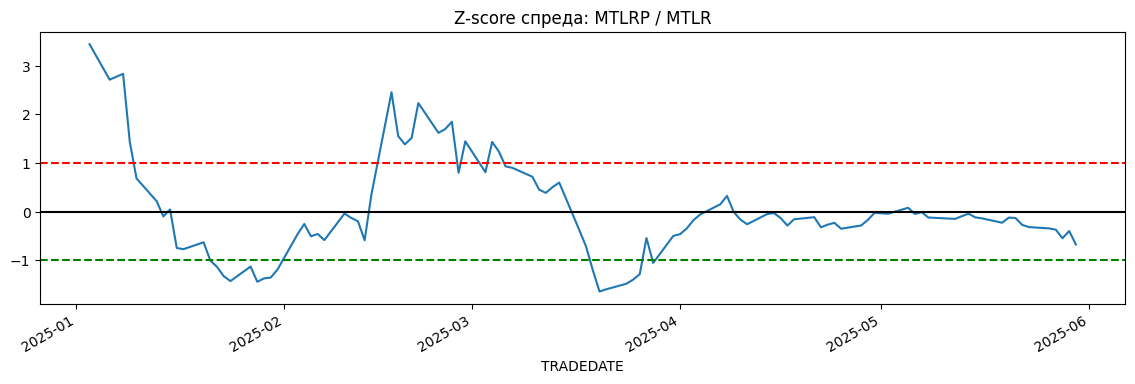

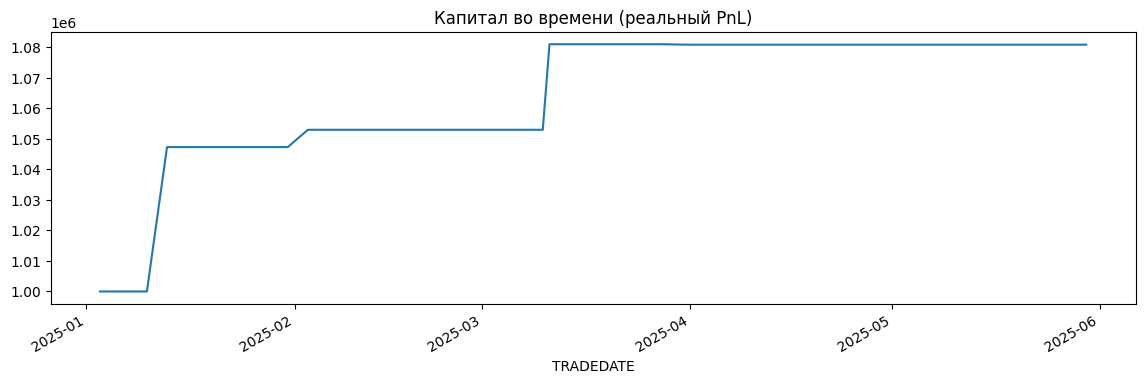

Финальная сумма: 1080756.28 ₽  |  Доходность: 8.08%


In [31]:
# Пример использования
ticker1 = "MTLRP"
ticker2 = "MTLR"

results = pair_trading_sim_realistic(price_matrix, ticker1, ticker2)